In [4]:
# do history matching on the original stage 5/6/7 to match the wave front
# Then I can do the simulation
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [5]:
# 1. do the history matching for the stage 7 and stage 8
# Load the data from stage 7
datapath = "./"
import os

# Stage 7 DAS/gauge data history matching

In [6]:
coeff = 0.3

## Plot the LF-DAS/gauge data at stage 7/S well

In [7]:
# Load DAS data
stage = 7 

# file path
DASdata_filepath = datapath + f"s_well/DASdata/LFDASdata_stg{stage}_swell.npz"
gauge_data_folder = datapath + "s_well/gauge_data/"
pumping_curve_filepath = datapath + f"prod/pumping_curve/pumping_curve_stage{stage}.npz"

# Load the geometry
gauge_md_geometry = datapath + "s_well/geometry/gauge_md_swell.npz"
frac_hit_geometry = datapath + f"s_well/geometry/frac_hit/frac_hit_stage_{stage}_swell.npz"

In [8]:
# Load the data
from DSS_analyzer_Mariner import Data1D_GAUGE, Data2D_XT_DSS, Data3D_geometry, Data1D_PumpingCurve

pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)
gauge_md_geometry_dataframe = Data3D_geometry.Data3D_geometry(gauge_md_geometry)
frac_hit_geometry_dataframe = Data3D_geometry.Data3D_geometry(frac_hit_geometry)
DASdata = Data2D_XT_DSS.Data2D()
DASdata.loadnpz(DASdata_filepath)

In [9]:
# Plot the DAS data with gauge data. Then I'll crop the depth and time range.
start_time = pumping_curve_dataframe.get_start_time()
end_time = pumping_curve_dataframe.get_end_time()

# Load the depth range of the DAS data, from the geometry file <- frac_hit
depth_range = np.array([np.min(frac_hit_geometry_dataframe.data) - 600, np.max(frac_hit_geometry_dataframe.data) + 300])

In [10]:
print(f"Depth range: {depth_range} ft")

Depth range: [14586.83 15664.29] ft


In [11]:
# Use depth data to crop the DAS data and find the guage data in the depth range
ind = np.array(np.where(np.logical_and(gauge_md_geometry_dataframe.data <= depth_range[1], gauge_md_geometry_dataframe.data >= depth_range[0]))).flatten()

In [12]:
print(f"Index of the gauge data in the depth range: {ind}")

Index of the gauge data in the depth range: [4 5 6 7]


In [13]:
# Crop the DAS data using the depth range
DASdata.select_depth(depth_range[0], depth_range[1])

In [14]:
# Load the gauge data. I have the index.
gauge_dataframe_all = []
for iter in tqdm(ind):
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"gauge{iter+1}_data_swell.npz") # +1 because the gauge index starts from 1
    gauge_dataframe.crop(start_time, end_time) # crop the data to the pumping time to match the DAS data
    gauge_dataframe_all.append(gauge_dataframe)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.82s/it]


In [15]:
DASdata.cal_timestamp_from_taxis()
cx = np.array([-1, 1])

In [16]:
from datetime import timedelta

In [17]:
# Form the scalar
tmp_taxis = np.repeat(gauge_dataframe_all[0].taxis[0] + timedelta(minutes=10), 2)
scalar_value = 300
tmp_value = np.array([ gauge_md_geometry_dataframe.data[ind][0] - 50, (scalar_value * - coeff + gauge_md_geometry_dataframe.data[ind][0] - 50)])

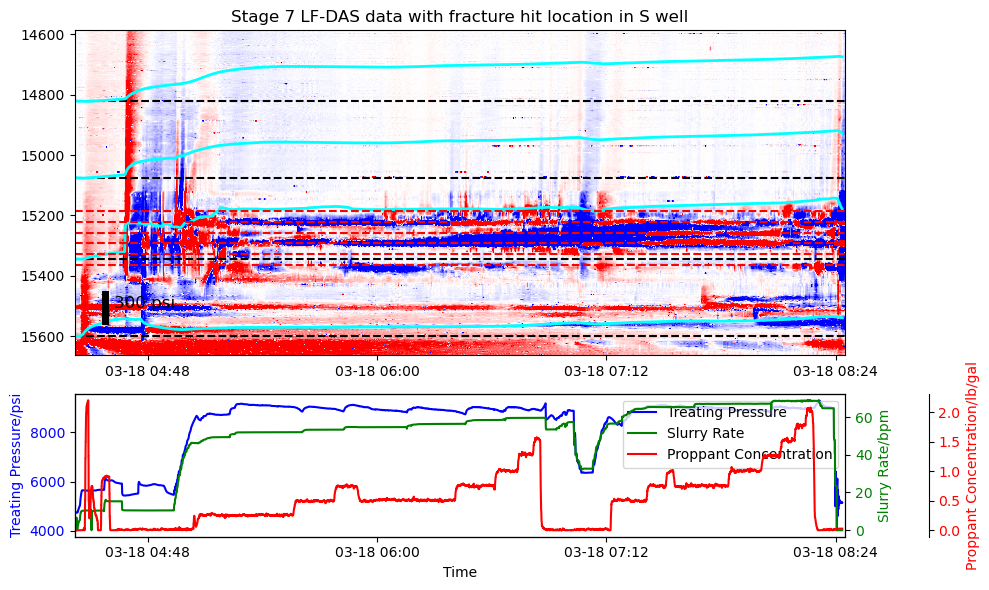

In [18]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((6, 4), (0, 0), rowspan=4, colspan=4)
for i in range(len(gauge_md_geometry_dataframe.data[ind])):
    ax1.axhline(y=gauge_md_geometry_dataframe.data[ind][i], color='black', linestyle='--')
    ax1.plot(gauge_dataframe_all[i].taxis, (gauge_dataframe_all[i].data - gauge_dataframe_all[i].data[0]) * - coeff + gauge_md_geometry_dataframe.data[ind][i], color='cyan', linewidth=2)
ax1.plot(tmp_taxis, tmp_value, color = 'black', linewidth=5) # scalar
ax1.text(tmp_taxis[0] + timedelta(minutes=3), tmp_value[0] - scalar_value/7, f"{scalar_value} psi", fontsize=12, color='black')
img1 = DASdata.plot_water_on_ax(ax1, use_timestamp=True)
img1.set_clim(cx * 1e3)
plt.title(f"Stage {stage} LF-DAS data with fracture hit location in S well")
# Plot the fracture hit location
for i in range(len(frac_hit_geometry_dataframe.data)):
    ax1.axhline(y=frac_hit_geometry_dataframe.data[i], color='red', linestyle='--')

ax2 = plt.subplot2grid((6, 4), (4, 0), rowspan=2, colspan=4, sharex=ax1)
pumping_curve_dataframe.plot_all_vars(ax2)

plt.tight_layout()
plt.show()

## Set up history matching grid

In [19]:
# Crop the data to get the window
# History matching
# Parameter setup
start_injection_time = datetime(2020, 3, 18, 4, 38, 00)
# Define diffusivity
d = 700 # ft^2/s

# end time will do no matter what
end_injection_time = datetime(2020, 3, 18, 4, 46, 00)

In [20]:
# Based on the LFDAS data, set up the space-time window
x = np.linspace(DASdata.mds[0], DASdata.mds[-1], len(DASdata.mds))
t = DASdata.taxis

dx = x[1] - x[0]
dt = t[1] - t[0]

nx = len(x)
nt = len(t)

U = np.zeros(nx) # solution at the current time step
U_snapshot = np.zeros((nx, nt)) # solution at each time step

## Look at the DAS data

In [21]:
DASdata_new = DASdata.copy()
DASdata_new.select_time(start_injection_time, end_injection_time)

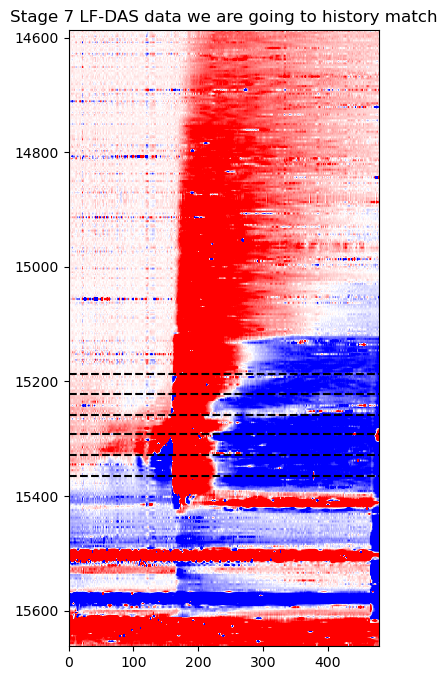

In [22]:
# Plot the cropped DAS data
fig, ax = plt.subplots(figsize=(4, 8))
img = DASdata_new.plot_water_on_ax(ax, use_timestamp=False)
img.set_clim(cx * 1e3)
for i in range(len(frac_hit_geometry_dataframe.data)):
    ax.axhline(y=frac_hit_geometry_dataframe.data[i], color='black', linestyle='--')
plt.title(f"Stage {stage} LF-DAS data we are going to history match")
plt.show()